# 良質なワインは何で決まるかをXGBoostで検証する  

In [1]:
%config IPCompleter.greedy=True  # 予測変換をつけます。

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.cross_validation import train_test_split 
import matplotlib.pyplot as plt

/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## データセットの読み込みと加工

In [3]:
# 赤ワイン・白ワインのcsvを読み込む
#redwine_df = pd.read_csv("winequality-red.csv", header=None, sep= ';')
redwine_df = pd.read_csv("winequality-red.csv", sep= ';')
#whitewine_df = pd.read_csv("winequality-white.csv", header=None,sep= ';')
whitewine_df = pd.read_csv("winequality-white.csv",sep= ';')
# csvを結合
wine_df = pd.concat([redwine_df, whitewine_df])
wine_df.head(20)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.600,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.650,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.580,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.500,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [4]:
# quality列が6以上の高品質ワインを1に変換、それ以外を0に変換
Y = wine_df["quality"].values
wine_df["quality"] = np.asarray([1 if i >= 6 else 0 for i in Y])
wine_df
#wine_df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.400000,0
1,7.8,0.880,0.00,2.60,0.098,25.0,67.0,0.99680,3.20,0.68,9.800000,0
2,7.8,0.760,0.04,2.30,0.092,15.0,54.0,0.99700,3.26,0.65,9.800000,0
3,11.2,0.280,0.56,1.90,0.075,17.0,60.0,0.99800,3.16,0.58,9.800000,1
4,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.400000,0
5,7.4,0.660,0.00,1.80,0.075,13.0,40.0,0.99780,3.51,0.56,9.400000,0
6,7.9,0.600,0.06,1.60,0.069,15.0,59.0,0.99640,3.30,0.46,9.400000,0
7,7.3,0.650,0.00,1.20,0.065,15.0,21.0,0.99460,3.39,0.47,10.000000,1
8,7.8,0.580,0.02,2.00,0.073,9.0,18.0,0.99680,3.36,0.57,9.500000,1
9,7.5,0.500,0.36,6.10,0.071,17.0,102.0,0.99780,3.35,0.80,10.500000,0


## 学習用・テスト用データに分けて、DMatrixの形式にする

In [5]:
df_train = wine_df
df_X = df_train.iloc[:, 0:11]
df_y = df_train["quality"]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=1) # random_stateって何だっけ
feature_names = wine_df.columns[0:11].tolist()

df_X_train = pd.DataFrame(X_train)
dtrain = xgb.DMatrix(df_X_train.as_matrix(), label=y_train.tolist(), feature_names=feature_names)

df_X_test = pd.DataFrame(X_test)
dtest = xgb.DMatrix(df_X_test.as_matrix(), label=y_test.tolist(), feature_names=feature_names)

## XGBoostの学習パラメータを設定

In [6]:
params = {"objective" : "binary:logistic",
          "eval_metric": "logloss",
         "eta": 0.3,
         "max_depth": 6,
         "min_child_weight": 1,
         "subsample": 1,
         "colsample_bytree": 1}

## 学習

In [7]:
bst = xgb.train(params, dtrain, evals=[(dtest, 'eval')], early_stopping_rounds=10)
print(bst.best_score)
print(bst.best_iteration)
print(bst.best_ntree_limit)

[0]	eval-logloss:0.611141
Will train until eval-logloss hasn't improved in 10 rounds.
[1]	eval-logloss:0.564837
[2]	eval-logloss:0.536385
[3]	eval-logloss:0.518332
[4]	eval-logloss:0.504534
[5]	eval-logloss:0.495354
[6]	eval-logloss:0.488136
[7]	eval-logloss:0.481921
[8]	eval-logloss:0.479299
[9]	eval-logloss:0.47656
0.47656
9
10


## 特徴量の重要度をグラフで表示  

### 特徴量について
- 揮発酸は低い方が良い。酸化していないワイン。  
- 硫酸（sulphates）は保存料として使用される。
- 二酸化硫黄なし(free sulfur dioxide)：二酸化硫黄は酸化防止のため添加される。  
- 残存糖は糖分が発酵されて残ったもの。ワインの甘みに関係する。  
- クエン酸（citric acid）はワインの酸性度を上げるために使用されるが、基本的には使われないはず。  
- 不揮発酸（fixed acidity）：少ない方がいいのかな？  

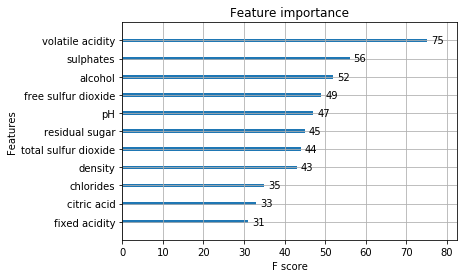

In [8]:
imp = bst.get_fscore()
xgb.plot_importance(bst)
plt.show()
# 重要度=分岐の回数

# ハイパーパラメーターチューニング

## やり方のメモ

以下の２通りの方法がある？

### 1. Scikit-LearnのGridSearchで調整        
  
参考：[hiromuberさんのgit hub](https://github.com/ireptechorg/xgboost/blob/master/Flow_XGboost.ipynb)  
  
  
### 2. hyperoptで調整（以下はこちらに挑戦しています）
- 最適なパラメーターをhyperoptで決める。  
- 仕様は理解していないが、ランダムサーチかTree-structured Parzen Estimatorで最適なパラメーターパターンを検出する模様？  
- その後、最適化したパラメーターで学習・検証を行う。その際に、sk-learnのcross_validationとKFoldを使ってk分割交差検証で学習・検証する。   
  
参考：[KAZ　logさんのサイト](http://tkzs.hatenablog.com/entry/2015/10/06/015530)  


In [10]:
#from sklearn.cross_validation import KFold 
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix, log_loss
#from sklearn import preprocessing  #これなんだ？

from hyperopt  import fmin, tpe, hp, STATUS_OK, Trials

## 学習用データ・テスト用データに分ける

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.5, random_state=25) # random_state?
np.random.seed(25)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## hyperoptによるパラメーター最適化

In [27]:
# 最適な木を構築するメソッド
def score(params):
    N_boost_round = []
    Score = []
    
    skf = cross_validation.StratifiedKFold(y_train, n_folds=10, shuffle= True, random_state=25)
    
    for train, test in skf:
        # データセットがdataframeの場合trainとtestで行を抽出できないので、行番号指定用のlistを無理やり作って、行番号を挿入しています
        train_list = []
        test_list = []
        
        for t in train:
            train_list.append(t)
        
        for t in test:
            test_list.append(t)
        
        # データセットがirisのようにndarrayであれば、ilocは使わずそのままtrainとtestで行を抽出できます
        _X_train, _X_test, _y_train, _y_test = X_train.iloc[train_list], X_train.iloc[test_list], y_train.iloc[train_list], y_train.iloc[test_list]
        
        dtrain = xgb.DMatrix(_X_train, label=_y_train)
        dvalid= xgb.DMatrix(_X_test, label=_y_test)
        
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        
        model = xgb.train(params, dtrain, num_boost_round=150, evals=watchlist, early_stopping_rounds=10)
        predictions = model.predict(dvalid)
        
        N = model.best_iteration
        N_boost_round.append(N)
        
        score = model.best_score
        Score.append(score)
        
        average_best_num_boost_round = np.average(N_boost_round)
        average_best_score = np.average(Score)
    
    print("Average of best_iteration: ", average_best_num_boost_round)
    print("Averaged Score: ",  average_best_score )
    
    return {'loss': average_best_score, 'status': STATUS_OK} # statusって何
    

# パラメーター最適化メソッド 
def optimize(trial):
    # 検索空間を定義する。scikit-learnの書き方で書ける。
    space = {
        "objective" : "binary:logistic",
        "eval_metrics" : "logloss",
    
        # 以下、パラメータ式がquniformでいいか要確認
        # モデルの複雑さを抑えるパラメーター(数字の意味をあとで調べる)
        "eta" : hp.quniform("eta", 0.2, 0.6, 0.05),  
        "max_depth" : hp.quniform("max_depth", 1, 10, 1),
        "min_child_weight" : hp.quniform("min_child_weight", 1, 10, 1),
        "gamma" : hp.quniform("gamma", 0, 1, 0.05),
    
        # ノイズへの堅牢性を高めるためのパラメーター
        "subsample" : hp.quniform("subsample", 0.5, 1, 0.05),
        "colsample_bytree": hp.quniform("colsample_bytree", 0.5, 1, 0.05),
    
        "silent" : 1 # Trueと書いてるサイトもある・・・
    }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=250)
    print("best parameters", best)

    
trials = Trials() #　トライアルオブジェクト。試行の過程を記録するインスタンス。
optimize(trials)


XGBoostError: b"Invalid Parameter format for max_depth expect int but value='6.0'"